# Multimodal vector search - Video

<!-- TABS -->
## Connect to superduper

In [3]:
from superduper import superduper
  
db = superduper('mongomock://test_db')
#db = superduper('sqlite://')

2024-Oct-18 22:11:43.14| INFO     | kartiks-MacBook-Air.local| superduper.misc.plugins:13   | Loading plugin: ibis
2024-Oct-18 22:11:43.15| WARNING  | kartiks-MacBook-Air.local| superduper_ibis.data_backend:107  | Unable to connect to the database with self.conn.con: <sqlite3.Connection object at 0x127812a70> and self.name: sqlite:. Error: 'sqlite3.Connection' object has no attribute 'dialect'.
2024-Oct-18 22:11:43.15| WARNING  | kartiks-MacBook-Air.local| superduper_ibis.data_backend:111  | Falling back to using the uri: sqlite://.
2024-Oct-18 22:11:43.16| INFO     | kartiks-MacBook-Air.local| superduper.backends.local.artifacts:32   | Creating artifact store directory
2024-Oct-18 22:11:43.16| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:73   | Building Data Layer
2024-Oct-18 22:11:43.16| INFO     | kartiks-MacBook-Air.local| superduper.base.build:177  | Configuration: 
 +---------------+-----------+
| Configuration |   Value   |
+---------------+-----------+
|  Dat

<!-- TABS -->
## Get useful sample data

In [4]:
#!curl -O https://superduperdb-public-demo.s3.amazonaws.com/videos.zip && unzip videos.zip
import os
from superduper.ext.pillow import pil_image

data = [f'videos/{x}' for x in os.listdir('./videos')]
sample_datapoint = data[-1]

chunked_model_datatype = pil_image

datas = [{'x': d} for d in data[:3]]

2024-Oct-18 22:11:48.05| WARNING  | kartiks-MacBook-Air.local| superduper.misc.annotations:336  | `superduper.ext.pillow` is deprecated and will be removed in a future release. Please insteall `superduper_pillow` and use `from superduper_pillow import *` instead.


<!-- TABS -->
## Create datatype

SuperduperDB supports automatic data conversion, so users don’t need to worry about the compatibility of different data formats (`PIL.Image`, `numpy.array`, `pandas.DataFrame`, etc.) with the database.

It also supports custom data conversion methods for transforming data, such as defining the following Datatype.

In [5]:
from superduper import DataType

# Create an instance of the Encoder with the identifier 'video_on_file' and load_hybrid set to False
datatype = DataType(
    identifier='video_on_file',
    encodable='file',
)

<!-- TABS -->
## Setup tables or collections

In [6]:
from superduper.components.table import Table
from superduper import Schema

schema = Schema(identifier="schema", fields={"x": datatype})
table = Table("docs", schema=schema)

In [7]:
db.apply(table)

2024-Oct-18 22:11:54.80| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:476  | Here are the CREATION EVENTS:
2024-Oct-18 22:11:54.80| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:482  | [0]: datatype:video_on_file:b006820e46954e0e8ecab5ff0764ae98: create ~ [1]
2024-Oct-18 22:11:54.80| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:482  | [1]: schema:schema:676e0ab9baf540c3a02c429698378b3a: create ~ [2]
2024-Oct-18 22:11:54.80| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:484  | [2]: table:docs:b88f7e5b1c4540c6af4458eca98a4156: create
2024-Oct-18 22:11:54.80| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:486  | JOBS EVENTS:
2024-Oct-18 22:11:54.80| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:499  | [0]: datatype:video_on_file:b006820e46954e0e8ecab5ff0764ae98: set_status
2024-Oct-18 22:11:54.80| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:499  | [1]: schema:sc

  Y


2024-Oct-18 22:11:57.25| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:621  | Component b006820e46954e0e8ecab5ff0764ae98 not found in cache, loading from db
2024-Oct-18 22:11:57.25| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:646  | Adding datatype:video_on_file:b006820e46954e0e8ecab5ff0764ae98 to cache
2024-Oct-18 22:11:57.25| INFO     | kartiks-MacBook-Air.local| superduper.components.component:560  | Adding datatype: video_on_file to cache
2024-Oct-18 22:11:57.26| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:621  | Component 676e0ab9baf540c3a02c429698378b3a not found in cache, loading from db
2024-Oct-18 22:11:57.26| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:646  | Adding schema:schema:676e0ab9baf540c3a02c429698378b3a to cache
2024-Oct-18 22:11:57.26| INFO     | kartiks-MacBook-Air.local| superduper.components.component:560  | Adding schema: schema to cache
2024-Oct-18 22:11:57.26| INFO     | kartiks-MacB

Table(identifier='docs', uuid='b88f7e5b1c4540c6af4458eca98a4156', upstream=None, plugins=None, cache=True, status=<Status.ready: 'ready'>, schema=Schema(identifier='schema', uuid='676e0ab9baf540c3a02c429698378b3a', upstream=None, plugins=None, cache=True, status=<Status.ready: 'ready'>, fields={'x': DataType(identifier='video_on_file', uuid='b006820e46954e0e8ecab5ff0764ae98', upstream=None, plugins=None, cache=True, status=<Status.ready: 'ready'>, encoder=None, decoder=None, info=None, shape=None, directory=None, encodable='file', bytes_encoding=<BytesEncoding.BYTES: 'bytes'>, intermediate_type='bytes', media_type=None), '_fold': FieldType(identifier='str', uuid='55d75b1c89554675a4a2be6253c485a9')}), primary_id='id')

In [8]:
db['docs'].insert(datas).execute()

2024-Oct-18 22:12:01.85| INFO     | kartiks-MacBook-Air.local| superduper.backends.local.artifacts:114  | Copying file videos/4.mp4 to .superduper/artifacts/ccdc38e8e3d7942bd7bc64bb13d4478e273bd6d7/4.mp4
2024-Oct-18 22:12:01.89| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:286  | Inserted 1 documents into docs
2024-Oct-18 22:12:01.89| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:341  | Skipping cdc for inserted documents in {table} because no component to consume the table.


['614cb65c-5349-40f0-b5fa-64105dee746a']

<!-- TABS -->
## Apply a chunker for search

:::note
Note that applying a chunker is ***not*** mandatory for search.
If your data is already chunked (e.g. short text snippets or audio) or if you
are searching through something like images, which can't be chunked, then this
won't be necessary.
:::

In [9]:
# !pip install opencv-python
import cv2
import tqdm
from PIL import Image
from superduper.ext.pillow import pil_image
from superduper import model, Schema


@model
def chunker(video_file):
    # Set the sampling frequency for frames
    sample_freq = 10
    
    # Open the video file using OpenCV
    cap = cv2.VideoCapture(video_file)
    
    # Initialize variables
    frame_count = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    extracted_frames = []
    progress = tqdm.tqdm()

    # Iterate through video frames
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Get the current timestamp based on frame count and FPS
        current_timestamp = frame_count // fps
        
        # Sample frames based on the specified frequency
        if frame_count % sample_freq == 0:
            extracted_frames.append({
                'image': Image.fromarray(frame[:,:,::-1]),  # Convert BGR to RGB
                'current_timestamp': current_timestamp,
            })
        frame_count += 1
        progress.update(1)
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()
    
    # Return the list of extracted frames
    return extracted_frames

Now we apply this chunker to the data by wrapping the chunker in `Listener`:

In [10]:
from superduper import Listener

upstream_listener = Listener(
    model=chunker,
    select=db['docs'].select(),
    key='x',
    identifier='chunker',
    flatten=True,
    upstream=[table]
)

In [11]:
db.apply(upstream_listener)

2024-Oct-18 22:12:06.58| INFO     | kartiks-MacBook-Air.local| superduper.backends.local.artifacts:127  | Loading file ccdc38e8e3d7942bd7bc64bb13d4478e273bd6d7 from .superduper/artifacts/
2024-Oct-18 22:12:06.58| INFO     | kartiks-MacBook-Air.local| superduper.backends.local.artifacts:127  | Loading file ccdc38e8e3d7942bd7bc64bb13d4478e273bd6d7 from .superduper/artifacts/


4491it [00:01, 3533.17it/s]


2024-Oct-18 22:12:09.13| WARNING  | kartiks-MacBook-Air.local| superduper.misc.annotations:336  | `superduper.ext.torch` is deprecated and will be removed in a future release. Please insteall `superduper_torch` and use `from superduper_torch import *` instead.
2024-Oct-18 22:12:09.14| WARNING  | kartiks-MacBook-Air.local| superduper.base.document:471  | Leaf ID already exists
2024-Oct-18 22:12:09.14| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:476  | Here are the CREATION EVENTS:
2024-Oct-18 22:12:09.14| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:482  | [0]: model:chunker:e718f93a8c244106b7138e49ee0ec23b: create ~ [3]
2024-Oct-18 22:12:09.14| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:482  | [1]: schema:_schema/_outputs__chunker__36befbcbede9423cbd19b4dccbed94dc:239d6abdf7674185bb39b12a697f4553: create ~ [2]
2024-Oct-18 22:12:09.14| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:482  | [2]: table:_outputs__c

  Y


2024-Oct-18 22:12:10.10| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:621  | Component e718f93a8c244106b7138e49ee0ec23b not found in cache, loading from db
2024-Oct-18 22:12:10.11| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:646  | Adding model:chunker:e718f93a8c244106b7138e49ee0ec23b to cache
2024-Oct-18 22:12:10.11| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:621  | Component 239d6abdf7674185bb39b12a697f4553 not found in cache, loading from db
2024-Oct-18 22:12:10.11| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:646  | Adding schema:_schema/_outputs__chunker__36befbcbede9423cbd19b4dccbed94dc:239d6abdf7674185bb39b12a697f4553 to cache
2024-Oct-18 22:12:10.12| INFO     | kartiks-MacBook-Air.local| superduper.components.component:560  | Adding schema: _schema/_outputs__chunker__36befbcbede9423cbd19b4dccbed94dc to cache
2024-Oct-18 22:12:10.12| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:621 

1it [00:00, 6278.90it/s]


2024-Oct-18 22:12:10.16| INFO     | kartiks-MacBook-Air.local| superduper.backends.local.artifacts:127  | Loading file ccdc38e8e3d7942bd7bc64bb13d4478e273bd6d7 from .superduper/artifacts/
2024-Oct-18 22:12:10.16| INFO     | kartiks-MacBook-Air.local| superduper.backends.local.artifacts:127  | Loading file ccdc38e8e3d7942bd7bc64bb13d4478e273bd6d7 from .superduper/artifacts/


4491it [00:01, 3547.77it/s]


2024-Oct-18 22:12:11.43| INFO     | kartiks-MacBook-Air.local| superduper.components.model:659  | Adding 1 model outputs to `db`
2024-Oct-18 22:12:12.66| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:286  | Inserted 450 documents into _outputs__chunker__36befbcbede9423cbd19b4dccbed94dc


Listener(identifier='chunker', uuid='36befbcbede9423cbd19b4dccbed94dc', upstream=[Table(identifier='docs', uuid='b88f7e5b1c4540c6af4458eca98a4156', upstream=None, plugins=None, cache=True, status=<Status.initializing: 'initializing'>, schema=Schema(identifier='schema', uuid='676e0ab9baf540c3a02c429698378b3a', upstream=None, plugins=None, cache=True, status=<Status.initializing: 'initializing'>, fields={'x': DataType(identifier='video_on_file', uuid='b006820e46954e0e8ecab5ff0764ae98', upstream=None, plugins=None, cache=True, status=<Status.initializing: 'initializing'>, encoder=None, decoder=None, info=None, shape=None, directory=None, encodable='file', bytes_encoding=<BytesEncoding.BYTES: 'bytes'>, intermediate_type='bytes', media_type=None), '_fold': FieldType(identifier='str', uuid='55d75b1c89554675a4a2be6253c485a9')}), primary_id='id')], plugins=None, cache=True, status=None, cdc_table='docs', key='x', model=ObjectModel(identifier='chunker', uuid='e718f93a8c244106b7138e49ee0ec23b', 

## Build multimodal embedding models

We define the output data type of a model as a vector for vector transformation.

In [11]:
# <tab: MongoDB>
from superduper.components.vector_index import vector
output_datatype = vector(shape=(1024,))

In [12]:
# <tab: SQL>
from superduper.components.vector_index import sqlvector
output_datatype = sqlvector(shape=(1024,))

Then define two models, one for text embedding and one for image embedding.

In [13]:
# !pip install git+https://github.com/openai/CLIP.git
import clip
from superduper import vector
from superduper_torch import TorchModel

# Load the CLIP model and obtain the preprocessing function
model, preprocess = clip.load("ViT-B/32", device='cpu')

# Create a TorchModel for text encoding
compatible_model = TorchModel(
    identifier='clip_text', # Unique identifier for the model
    object=model, # CLIP model
    preprocess=lambda x: clip.tokenize(x)[0],  # Model input preprocessing using CLIP 
    postprocess=lambda x: x.tolist(), # Convert the model output to a list
    datatype=output_datatype,  # Vector encoder with shape (1024,)
    forward_method='encode_text', # Use the 'encode_text' method for forward pass 
)

# Create a TorchModel for visual encoding
model = TorchModel(
    identifier='clip_image',  # Unique identifier for the model
    object=model.visual,  # Visual part of the CLIP model    
    preprocess=preprocess, # Visual preprocessing using CLIP
    postprocess=lambda x: x.tolist(), # Convert the output to a list 
    datatype=output_datatype, # Vector encoder with shape (1024,)
)

Because we use multimodal models, we define different keys to specify which model to use for embedding calculations in the vector_index.

## Create vector-index

In [16]:
from superduper import VectorIndex, Listener

vector_index = VectorIndex(
    'my-vector-index',
    indexing_listener=Listener(
        key=upstream_listener.outputs + '.image',      # the `Document` key `model` should ingest to create embedding
        select=db[upstream_listener.outputs].select(),       # a `Select` query telling which data to search over
        model=model,         # a `_Predictor` how to convert data to embeddings
        identifier=f'{model.identifier}-listener'
    ),
    compatible_listener=Listener(
        key='text',      # the `Document` key `model` should ingest to create embedding
        model=compatible_model,         # a `_Predictor` how to convert data to embeddings
        select=None,
        identifier='compatible-listener',
    ),
    upstream=[upstream_listener],
)

In [17]:
db.apply(vector_index)

2024-Oct-18 22:12:35.29| WARNING  | kartiks-MacBook-Air.local| superduper.base.document:471  | Leaf ID already exists
2024-Oct-18 22:12:35.76| WARNING  | kartiks-MacBook-Air.local| superduper.base.document:471  | Leaf datatype:dill already exists
2024-Oct-18 22:12:35.76| WARNING  | kartiks-MacBook-Air.local| superduper.base.document:471  | Leaf datatype:dill already exists
2024-Oct-18 22:12:36.56| WARNING  | kartiks-MacBook-Air.local| superduper.base.document:471  | Leaf datatype:dill already exists
2024-Oct-18 22:12:36.56| WARNING  | kartiks-MacBook-Air.local| superduper.base.document:471  | Leaf datatype:dill already exists
2024-Oct-18 22:12:36.97| WARNING  | kartiks-MacBook-Air.local| superduper.base.document:471  | Leaf datatype:dill already exists
2024-Oct-18 22:12:36.97| WARNING  | kartiks-MacBook-Air.local| superduper.base.document:471  | Leaf datatype:dill already exists
2024-Oct-18 22:12:37.97| WARNING  | kartiks-MacBook-Air.local| superduper.base.document:471  | Leaf datatype

  Y


2024-Oct-18 22:12:41.53| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:621  | Component 2a5bd86a530b42359dd6cf1c361237cf not found in cache, loading from db


/Users/kartiksharma/Work/superduperdb/code/superduper/.venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.loa

2024-Oct-18 22:12:42.03| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:646  | Adding model:clip_image:2a5bd86a530b42359dd6cf1c361237cf to cache
2024-Oct-18 22:12:42.03| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:621  | Component d724ecb4e48d49cfbd76fe50a423feb4 not found in cache, loading from db
2024-Oct-18 22:12:42.04| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:646  | Adding schema:_schema/_outputs__clip_image-listener__fa65aac5a64548ffb93cddf596338d76:d724ecb4e48d49cfbd76fe50a423feb4 to cache
2024-Oct-18 22:12:42.04| INFO     | kartiks-MacBook-Air.local| superduper.components.component:560  | Adding schema: _schema/_outputs__clip_image-listener__fa65aac5a64548ffb93cddf596338d76 to cache
2024-Oct-18 22:12:42.04| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:621  | Component 55efba5beea945babe83e7690a415a1d not found in cache, loading from db
2024-Oct-18 22:12:42.04| INFO     | kartiks-MacBook-Air.local| sup

450it [00:00, 15277.45it/s]
100%|██████████████████████████████████████████████████| 450/450 [00:27<00:00, 16.34it/s]


2024-Oct-18 22:13:10.95| INFO     | kartiks-MacBook-Air.local| superduper.components.model:659  | Adding 450 model outputs to `db`
2024-Oct-18 22:13:12.09| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:286  | Inserted 450 documents into _outputs__clip_image-listener__fa65aac5a64548ffb93cddf596338d76


VectorIndex(identifier='my-vector-index', uuid='d8875bc98cb5426cbf79060afcfd7bed', upstream=[Listener(identifier='chunker', uuid='36befbcbede9423cbd19b4dccbed94dc', upstream=[Table(identifier='docs', uuid='b88f7e5b1c4540c6af4458eca98a4156', upstream=None, plugins=None, cache=True, status=<Status.initializing: 'initializing'>, schema=Schema(identifier='schema', uuid='676e0ab9baf540c3a02c429698378b3a', upstream=None, plugins=None, cache=True, status=<Status.initializing: 'initializing'>, fields={'x': DataType(identifier='video_on_file', uuid='b006820e46954e0e8ecab5ff0764ae98', upstream=None, plugins=None, cache=True, status=<Status.initializing: 'initializing'>, encoder=None, decoder=None, info=None, shape=None, directory=None, encodable='file', bytes_encoding=<BytesEncoding.BYTES: 'bytes'>, intermediate_type='bytes', media_type=None), '_fold': FieldType(identifier='str', uuid='55d75b1c89554675a4a2be6253c485a9')}), primary_id='id')], plugins=None, cache=True, status=None, cdc_table='docs

In [16]:
from superduper import Application

app = Application(
    'video-search',
    components=[
        upstream_listener,
        vector_index,
    ]
)

In [17]:
db.apply(app)

2024-Oct-18 22:08:30.67| WARNING  | kartiks-MacBook-Air.local| superduper.base.document:471  | Leaf ID already exists
2024-Oct-18 22:08:30.68| WARNING  | kartiks-MacBook-Air.local| superduper.base.document:471  | Leaf ID already exists
2024-Oct-18 22:08:31.51| WARNING  | kartiks-MacBook-Air.local| superduper.base.document:471  | Leaf datatype:dill already exists
2024-Oct-18 22:08:31.51| WARNING  | kartiks-MacBook-Air.local| superduper.base.document:471  | Leaf datatype:dill already exists
2024-Oct-18 22:08:32.75| WARNING  | kartiks-MacBook-Air.local| superduper.base.document:471  | Leaf datatype:dill already exists
2024-Oct-18 22:08:32.75| WARNING  | kartiks-MacBook-Air.local| superduper.base.document:471  | Leaf datatype:dill already exists
2024-Oct-18 22:08:32.77| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:476  | Here are the CREATION EVENTS:
2024-Oct-18 22:08:32.77| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:484  | [0]: application:video-sea

  Y


2024-Oct-18 22:08:40.65| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:621  | Component 190d67c1571448bb836f2e21a1298b6d not found in cache, loading from db
2024-Oct-18 22:08:40.65| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:646  | Adding application:video-search:190d67c1571448bb836f2e21a1298b6d to cache
2024-Oct-18 22:08:40.65| INFO     | kartiks-MacBook-Air.local| superduper.components.component:560  | Adding application: video-search to cache


Application(identifier='video-search', uuid='190d67c1571448bb836f2e21a1298b6d', upstream=None, plugins=None, cache=True, status=<Status.ready: 'ready'>, components=[Listener(identifier='chunker', uuid='0c9b08c6ac6f4df18483a4424bccd4a3', upstream=[Table(identifier='docs', uuid='e3c06b013d0e48e182006d4b75155820', upstream=None, plugins=None, cache=True, status=<Status.initializing: 'initializing'>, schema=Schema(identifier='schema', uuid='28023654b88542b6913e96d24de3d07b', upstream=None, plugins=None, cache=True, status=<Status.initializing: 'initializing'>, fields={'x': DataType(identifier='video_on_file', uuid='ae955820799b45f4a2680900a4694a03', upstream=None, plugins=None, cache=True, status=<Status.initializing: 'initializing'>, encoder=None, decoder=None, info=None, shape=None, directory=None, encodable='file', bytes_encoding=<BytesEncoding.BYTES: 'bytes'>, intermediate_type='bytes', media_type=None), '_fold': FieldType(identifier='str', uuid='e772a53786b2475baf7fb17f8979b50f')}), p

## Perform a vector search

We can perform the vector searches using text description:

In [18]:
from superduper import Document
item = Document({'text': "A single red and a blue player battle for the ball"})

In [21]:
from superduper import Document
item = Document({'text': "Some monkeys playing"})

Once we have this search target, we can execute a search as follows.

In [19]:
select = db[upstream_listener.outputs].like(item, vector_index='my-vector-index', n=5).select()
results = list(db.execute(select))

2024-Oct-18 22:13:24.99| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:961  | Getting vector-index
2024-Oct-18 22:13:24.99| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:969  | {}


## Visualize Results

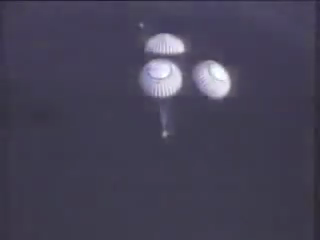

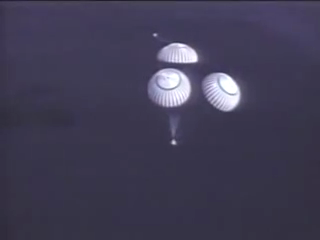

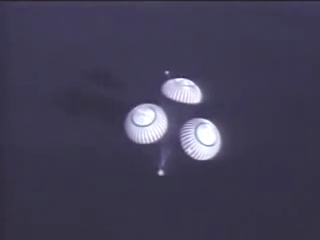

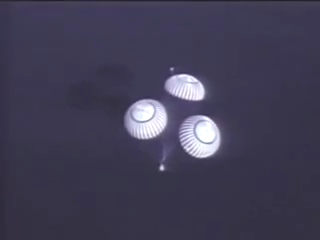

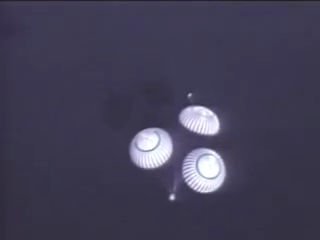

In [20]:
from IPython.display import display
for result in results:
    display(Document(result.unpack())[upstream_listener.outputs + '.image'])

## Check the system stays updated

You can add new data; once the data is added, all related models will perform calculations according to the underlying constructed model and listener, simultaneously updating the vector index to ensure that each query uses the latest data.

In [ ]:
new_datas = [{'x': data[-1]}]
ids = db['docs'].insert(new_datas).execute()

2024-Oct-18 22:09:05.73| INFO     | kartiks-MacBook-Air.local| superduper.backends.local.artifacts:114  | Copying file videos/3.mp4 to /tmp/test_db/20943fe19fe8249be4c0099cd728faca8b148367/3.mp4
2024-Oct-18 22:09:05.74| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:286  | Inserted 1 documents into docs
2024-Oct-18 22:09:05.74| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:351  | Created 1 events for insert on [docs]
2024-Oct-18 22:09:05.74| INFO     | kartiks-MacBook-Air.local| superduper.base.datalayer:352  | Publishing 1 events
Streaming with listener:chunker
Streaming with listener:clip_image-listener
Streaming with vector_index:my-vector-index
2024-Oct-18 22:09:05.75| INFO     | kartiks-MacBook-Air.local| superduper.components.model:526  | Requesting prediction in db - [chunker] with predict_id chunker__0c9b08c6ac6f4df18483a4424bccd4a3

2024-Oct-18 22:09:05.76| INFO     | kartiks-MacBook-Air.local| superduper.backends.local.artifacts:127  | Loadi

1074it [00:03, 305.78it/s]


2024-Oct-18 22:09:09.31| INFO     | kartiks-MacBook-Air.local| superduper.components.model:659  | Adding 1 model outputs to `db`


In [ ]:
from superduper import Template

t = Template('video-search-template', template=app, substitutions={'docs': 'content_table'})

In [ ]:
t.export('.')